### View the effect of the augmentations on the MRI patches and masks

In [13]:
import os
import numpy as np
import torchio as tio
import nibabel as nib
import matplotlib.pyplot as plt
import sys
import copy
import pytorch_msssim
import torch


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from VAE.utils.utility_code import find_centers_and_bounding_boxes_32

# get file names for mri and mask files
dir = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_preprocessed"
mri_nii_paths, mask_nii_paths = [], []
for root, _, files in os.walk(dir):
    for file in files:
        if file.endswith('.nii') and 'mri' in file:
            mri_nii_paths.append(os.path.join(root, file))
        if file.endswith('.nii') and 'mask' in file:
            mask_nii_paths.append(os.path.join(root, file))

mri_shapes = {}
# check that the mri and mask files are correctly matched and get shapes
for i in range(len(mri_nii_paths)):
    #print(mri_nii_paths[i][63:72], mask_nii_paths[i][63:72])
    assert mri_nii_paths[i][63:72] == mask_nii_paths[i][63:72]      # pat_id == pat_id 
    
    # Load image using nibabel
    img = nib.load(mask_nii_paths[i])
    # Get the image data
    img_data = img.get_fdata()
    # get shape 
    mri_shapes[mri_nii_paths[i]] = img_data.shape
    
    
    
bounding_boxes_dict = np.load(r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\bounding_boxes.npy", allow_pickle=True).item()


In [5]:
example_noise = [int(np.random.normal(0, 6)) for _ in range(50)]
print('Example noise', example_noise)

def add_noise_to_bbox(bboxes):
    new_bboxes = copy.deepcopy(bboxes)
    for key, bbox in bboxes.items():
        x_change = int(np.random.normal(0, 6))
        y_change = int(np.random.normal(0, 6))
        
        # set max noise to be +/- 8
        if x_change > 8:
            x_change = 8
        if x_change < -8:
            x_change = -8
        if y_change > 8:
            y_change = 8
        if y_change < -8:
            y_change = -8
    
        
        mri_shape = mri_shapes[mri_nii_paths[0]]
        center = bbox['center']
        
        #print('Original', bbox['bounding_box'])
        new_x_min = bbox['bounding_box'][0][1] + x_change
        new_x_max = bbox['bounding_box'][1][1] + x_change
        new_y_min = bbox['bounding_box'][0][2] + y_change
        new_y_max = bbox['bounding_box'][1][2] + y_change
        
        # check new bounding box is within image
        assert new_x_min >= 0 and new_x_max < mri_shape[0] and new_y_min >= 0 and new_y_max < mri_shape[1]
        # check centre is still within bounding box
        assert new_x_min < center[1] < new_x_max and new_y_min < center[2] < new_y_max
        
        new_bbox = ((bbox['bounding_box'][0][0], new_x_min, new_y_min), (bbox['bounding_box'][1][0], new_x_max, new_y_max))
        new_bboxes[key]['bounding_box'] = new_bbox
        #print('New bbox', new_bbox)
    return new_bboxes

add_noise_to_bbox(bounding_boxes_dict[mask_nii_paths[0]])

Example noise [2, 5, 7, -1, -10, 1, 8, -3, 9, 11, 0, -7, -1, -12, 0, 15, -9, -3, 7, 15, 1, -3, -4, -2, 6, -13, 12, -13, 9, 0, 1, -6, 4, 1, 1, -2, -1, 15, -10, -11, 1, 3, 4, 1, 0, 7, -5, 3, 1, 11]


{(1.0, 9): {'center': (9, 168, 137),
  'bounding_box': ((9, 148, 128), (9, 179, 159))},
 (2.0, 12): {'center': (12, 167, 121),
  'bounding_box': ((12, 151, 107), (12, 182, 138))},
 (3.0, 15): {'center': (15, 166, 130),
  'bounding_box': ((15, 157, 112), (15, 188, 143))},
 (4.0, 16): {'center': (16, 148, 133),
  'bounding_box': ((16, 135, 113), (16, 166, 144))},
 (5.0, 18): {'center': (18, 161, 92),
  'bounding_box': ((18, 150, 83), (18, 181, 114))},
 (6.0, 21): {'center': (21, 148, 161),
  'bounding_box': ((21, 125, 140), (21, 156, 171))}}

In [38]:
def crop_and_plot(subject, idx, bboxes_dict):
    bbox_key, bbox_info = list(bboxes_dict.items())[idx]
    bbox = bbox_info['bounding_box']

    # Get bounding box coordinates (in format (x_min, y_min, z_min), (x_max, y_max, z_max))
    z_min, x_min, y_min = bbox[0]
    z_max, x_max, y_max = bbox[1]

    for key, img in subject.items():
        data = img.data   # Convert to a PyTorch tensor
        #print(key, data.shape)
        cropped_data = data[:, x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]
        

        assert cropped_data.shape == (1, 32, 32, 1)
        if key == 'mri':
            mri = tio.ScalarImage(tensor=cropped_data, affine=img.affine)
        if key == 'mask':
            mask = tio.LabelMap(tensor=cropped_data, affine=img.affine)

    cropped_subject = tio.Subject(mri=mri, mask=mask)
    cropped_subject.plot()
    return cropped_subject

96
Augmentation 0
shape torch.Size([1, 1, 27, 384, 384]) torch.Size([1, 1, 27, 384, 384])
Full scan SSIM: tensor(0.1325)
Original


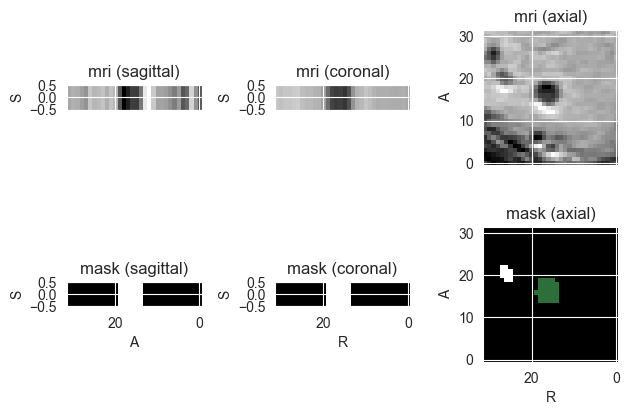

Augmented


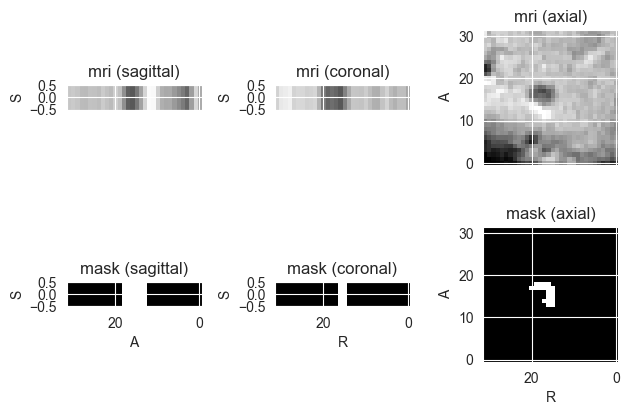

Original vs Augmented SSIM: tensor(0.2601)
Augmented and noise


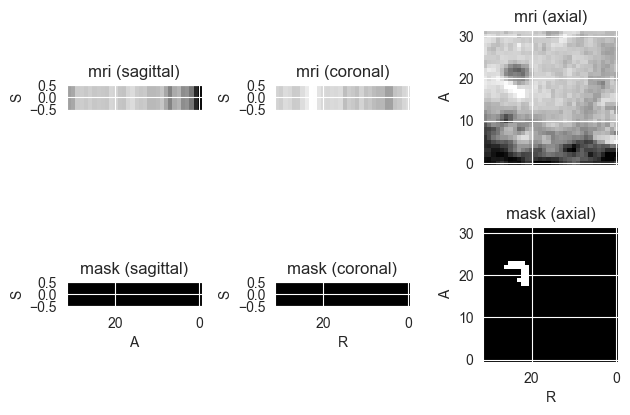

Original vs Augmented with noise: tensor(0.3271)
Original


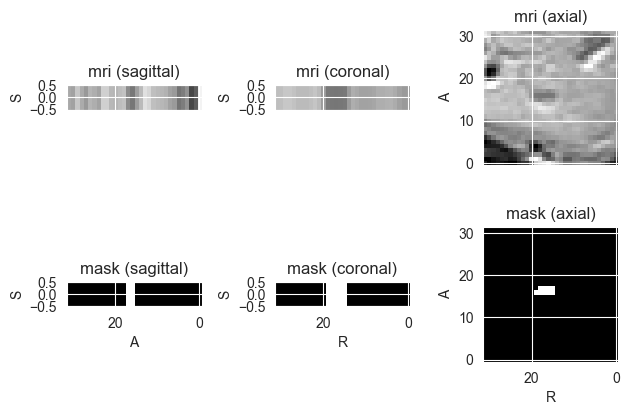

Augmented


KeyboardInterrupt: 

In [44]:
bounding_boxes_dict = np.load(r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\bounding_boxes.npy", allow_pickle=True).item()

for idx in list(np.random.randint(0, len(mri_nii_paths), 5)):
    print(idx)
    mri_path = mri_nii_paths[idx]
    mask_path = mask_nii_paths[idx]
    assert mri_nii_paths[idx][63:72] == mask_nii_paths[idx][63:72] # check same patient id
    
    original_bbox = bounding_boxes_dict[mask_path]
    keys = list(original_bbox.keys())
    
    augment = tio.Compose([
        tio.RandomBlur(std=(0, 0.05), p=0.3),              # blur 
        tio.RandomNoise(mean=0, std=(0, 0.05), p=0.3),     # Gaussian noise 
        tio.RandomFlip(axes=(0, 1, 2), p=0.75),            # flip 60% of times
        tio.RandomGamma(log_gamma=(-0.3, 0.3), p=0.3),     # Adjusts gamma with specified range and probability
        tio.RandomBiasField(coefficients=0.25,             # magnetic field inhomogeneity 30% of times
                            order=3, p=0.3),
        tio.RandomAffine(                                  # Apply random affine transformation
        degrees=(15,15,0),    # Rotate in x and y but not slice dimension (z)
        translation=(0, 0, 0),  # No translation 
        scales=(1.0, 1.0),     # No scaling
        p=0.5),


        # maybe don't include scales and elastic as they change shape of node - matters more for the MLP
        # tio.RandomElasticDeformation(                  # or random elastic deformation
        #     num_control_points=5,
        #     max_displacement=2, p=0.3),
        

    
        # these augmentations may not be appropriate on 32x32 ROI
        # tio.OneOf({                                        # either
        #     tio.RandomMotion(degrees=5,                    # random motion artifact - changes image too much
        #                      translation=5): 0.2,
        #     tio.RandomSpike(num_spikes=1,                  # or spikes
        #                     intensity=0.75): 0.4,
        #     tio.RandomGhosting(num_ghosts=3,               # or ghosts
        #                        axes=(0, 1, 2),
        #                        intensity=0.5): 0.4,
        # }, p=0.5),      
        tio.RescaleIntensity(out_min_max=(0, 1))  # Normalize intensity values to the range [0, 1]
    ])
    for aug_idx in range(5): # 5 augmentations per image
        print('Augmentation', aug_idx)
        subject = tio.Subject(
            mri=tio.ScalarImage(mri_path),
            mask=tio.LabelMap(mask_path),
        )
        subject_aug = augment(subject)
        #assert pytorch_msssim.ssim(subject['mask'].data, subject_aug['mask'].data, data_range=1) == 1
        mri = torch.unsqueeze(subject['mri'].data.permute(0, 3, 1, 2), 0)
        mri_aug = torch.unsqueeze(subject_aug['mri'].data.permute(0, 3, 1, 2), 0)
        print('Full scan SSIM:', pytorch_msssim.ssim(mri, mri_aug, data_range=1))
        mask = subject_aug['mask'].data
        mask = np.squeeze(np.array(mask), 0)
        mask = np.transpose(mask, (2, 0, 1))
        bboxes_dict = find_centers_and_bounding_boxes_32(mask)
        noise_bboxes_dict = add_noise_to_bbox(bboxes_dict)
        
        for idx in range(len(bboxes_dict)):
            print('Original')
            original = crop_and_plot(subject, idx, original_bbox)            
            print('Augmented')
            augmented = crop_and_plot(subject_aug, idx, bboxes_dict)
            print('Original vs Augmented SSIM:', pytorch_msssim.ssim(original_mri, augmented_mri, data_range=1))
            print('Augmented and noise')
            augmented_and_noise = crop_and_plot(subject_aug, idx, noise_bboxes_dict)
            original_mri = original['mri'].data.permute(0, 3, 1, 2)
            augmented_mri = augmented['mri'].data.permute(0, 3, 1, 2)
            augmented_and_noise_mri = augmented_and_noise['mri'].data.permute(0, 3, 1, 2)
            assert original_mri.shape == augmented_mri.shape == augmented_and_noise_mri.shape == (1, 1, 32, 32)
            assert pytorch_msssim.ssim(original_mri, original_mri, data_range=1) == 1
            print('Original vs Augmented with noise:', pytorch_msssim.ssim(original_mri, augmented_and_noise_mri, data_range=1))
    
    

